<a href="https://colab.research.google.com/github/arun-nath/Nifty_EDA/blob/main/Nifty_IV_vs_RV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1560257582.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1560257582.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  india_vix = yf.download("^INDIAVIX", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


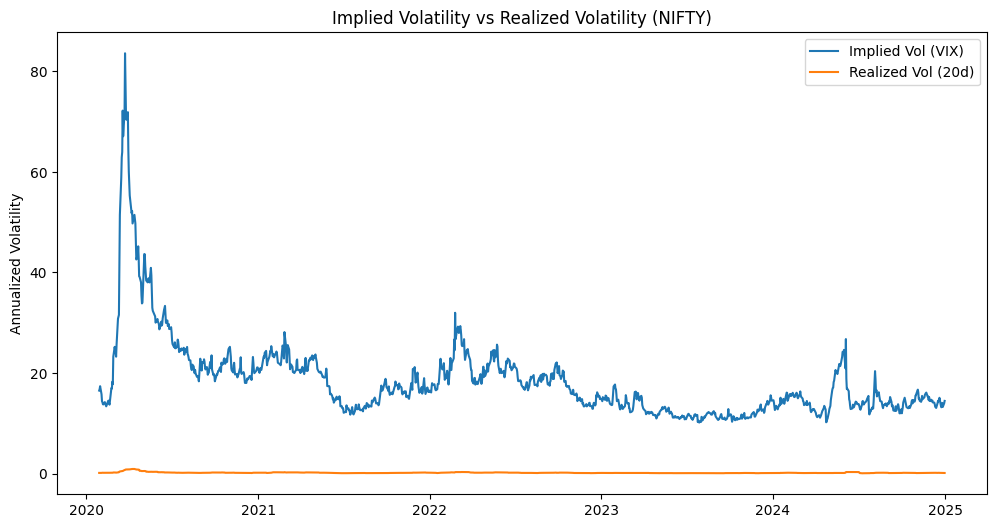

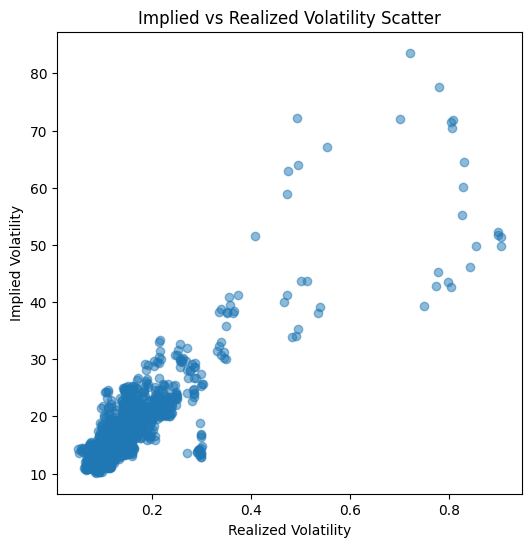

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Download underlying index (e.g. NIFTY) and VIX
nifty = yf.download("^NSEI", start="2020-01-01", end="2025-01-01")
india_vix = yf.download("^INDIAVIX", start="2020-01-01", end="2025-01-01")

# 2. Calculate daily log returns
nifty['log_ret'] = np.log(nifty['Close']).diff()

# 3. Compute realized volatility (20-day rolling, annualized)
window = 20
nifty['RV'] = nifty['log_ret'].rolling(window).std() * np.sqrt(252)

# 4. Align IV (India VIX is already annualized implied volatility)
iv_rv = pd.concat([nifty['RV'], india_vix['Close']], axis=1)
iv_rv.columns = ['Realized Vol', 'Implied Vol']
iv_rv.dropna(inplace=True)

# 5. Plot IV vs RV over time
plt.figure(figsize=(12,6))
plt.plot(iv_rv.index, iv_rv['Implied Vol'], label="Implied Vol (VIX)")
plt.plot(iv_rv.index, iv_rv['Realized Vol'], label="Realized Vol (20d)")
plt.legend()
plt.title("Implied Volatility vs Realized Volatility (NIFTY)")
plt.ylabel("Annualized Volatility")
plt.show()

# 6. Scatter plot (IV vs RV)
plt.figure(figsize=(6,6))
plt.scatter(iv_rv['Realized Vol'], iv_rv['Implied Vol'], alpha=0.5)
plt.xlabel("Realized Volatility")
plt.ylabel("Implied Volatility")
plt.title("Implied vs Realized Volatility Scatter")
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                  RV       IV    Spread  Spread_z
Date                                             
2025-11-12  0.074745  0.12110  0.046355  0.489590
2025-11-13  0.074532  0.12160  0.047068  0.505079
2025-11-14  0.074137  0.11940  0.045263  0.465886
2025-11-17  0.071121  0.11790  0.046779  0.498795
2025-11-18  0.072013  0.12115  0.049137  0.550011


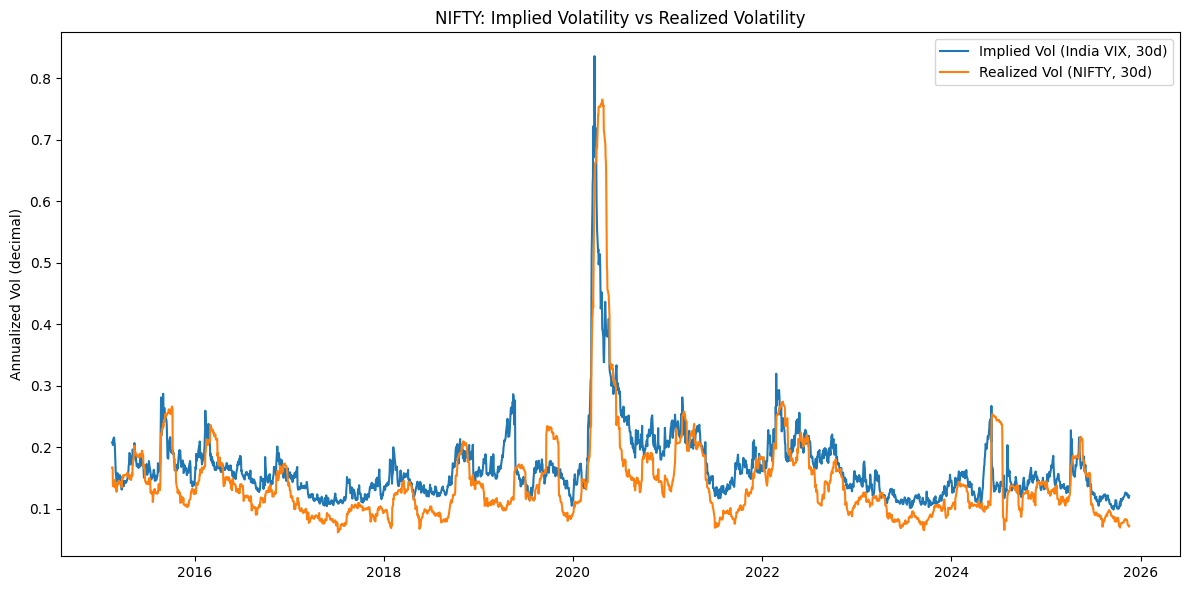

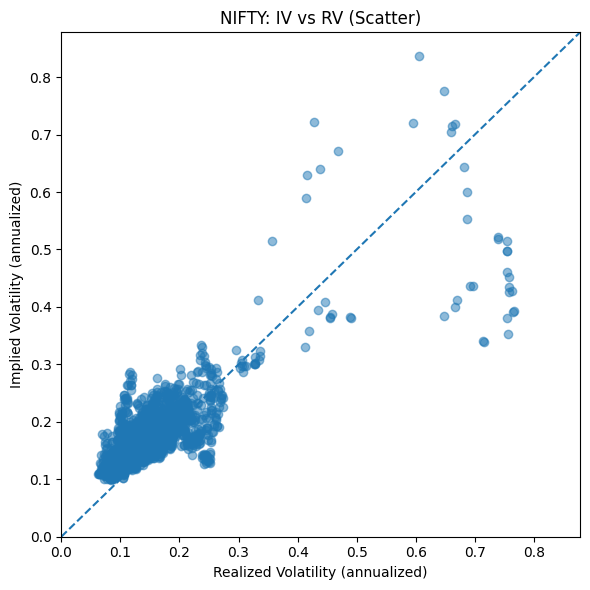

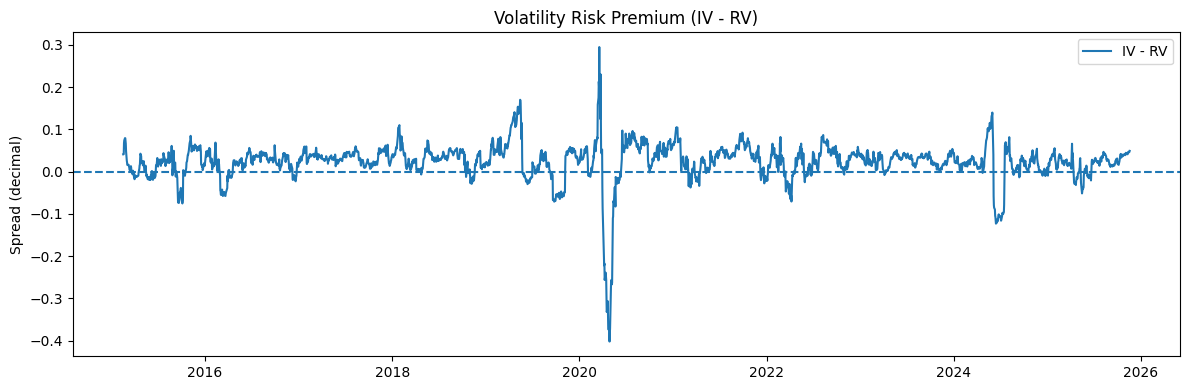

Summary: {'corr_IV_RV': 0.8209403335475535, 'avg_IV': 0.16705172864499426, 'avg_RV': 0.14324251882447925, 'avg_spread': 0.023809209820515008}


In [ ]:
# Tailored for Indian equities: NIFTY vs India VIX
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ---------- Config ----------
START = "2015-01-01"
END   = None                  # None = today
WINDOW = 30                   # ~1 month to match VIX horizon
TRADING_DAYS = 252

# ---------- Download data ----------
# NIFTY 50 Index
nifty = yf.download("^NSEI", start=START, end=END, auto_adjust=False)
# India VIX (quoted in percent, annualized)
ivix = yf.download("^INDIAVIX", start=START, end=END, auto_adjust=False)

# Basic sanity checks
if nifty.empty or ivix.empty:
    raise RuntimeError("Data download failed. Check tickers or your internet connection.")

# ---------- Realized Volatility (RV) from NIFTY ----------
nifty["log_ret"] = np.log(nifty["Close"]).diff()
# 30d rolling stdev of daily log returns, annualized
nifty["RV_30d"] = nifty["log_ret"].rolling(WINDOW).std() * np.sqrt(TRADING_DAYS)

# ---------- Implied Volatility (IV) from India VIX ----------
# India VIX is in percent; convert to decimal
ivix["IV"] = ivix["Close"] / 100.0

# ---------- Align on dates ----------
df = pd.concat(
    [
        nifty["RV_30d"].rename("RV"),
        ivix["IV"].rename("IV")
    ],
    axis=1
).dropna()

# Optional: smooth IV to NIFTY trading days (forward-fill if VIX missing certain days)
df["IV"] = df["IV"].ffill()

# ---------- Diagnostics ----------
df["Spread"] = df["IV"] - df["RV"]         # IV - RV
df["Spread_z"] = (df["Spread"] - df["Spread"].mean()) / df["Spread"].std()

print(df.tail())

# ---------- Plots ----------
plt.figure(figsize=(12,6))
plt.plot(df.index, df["IV"], label="Implied Vol (India VIX, 30d)")
plt.plot(df.index, df["RV"], label=f"Realized Vol (NIFTY, {WINDOW}d)")
plt.title("NIFTY: Implied Volatility vs Realized Volatility")
plt.ylabel("Annualized Vol (decimal)")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter: IV vs RV
plt.figure(figsize=(6,6))
plt.scatter(df["RV"], df["IV"], alpha=0.5)
# 45° line for reference
lims = [0, max(df["RV"].max(), df["IV"].max()) * 1.05]
plt.plot(lims, lims, linestyle="--")
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Realized Volatility (annualized)")
plt.ylabel("Implied Volatility (annualized)")
plt.title("NIFTY: IV vs RV (Scatter)")
plt.tight_layout()
plt.show()

# IV - RV spread over time
plt.figure(figsize=(12,4))
plt.plot(df.index, df["Spread"], label="IV - RV")
plt.axhline(0, linestyle="--")
plt.title("Volatility Risk Premium (IV - RV)")
plt.ylabel("Spread (decimal)")
plt.legend()
plt.tight_layout()
plt.show()

# If you want summary stats:
summary = {
    "corr_IV_RV": float(df["IV"].corr(df["RV"])),
    "avg_IV": float(df["IV"].mean()),
    "avg_RV": float(df["RV"].mean()),
    "avg_spread": float(df["Spread"].mean()),
}
print("Summary:", summary)


/tmp/ipython-input-4164057248.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start="2015-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4164057248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ivix  = yf.download("^INDIAVIX", start="2015-01-01")
[*********************100%***********************]  1 of 1 completed


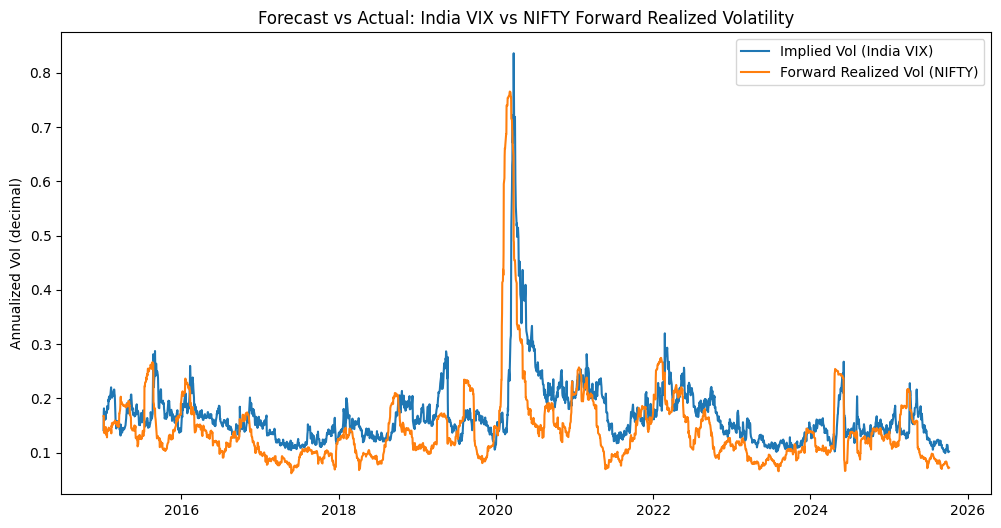

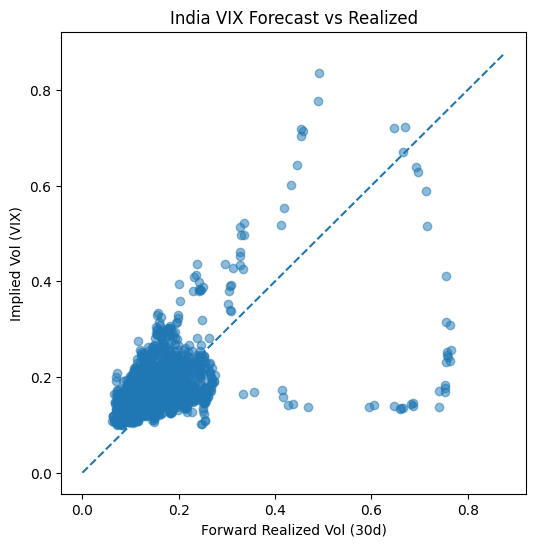

Correlation (IV vs FRV): 0.5568121131228148
Average Forecast Bias (IV - FRV): 0.024494855623520814


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------
# 1. Get Data
# -------------------
nifty = yf.download("^NSEI", start="2015-01-01")
ivix  = yf.download("^INDIAVIX", start="2015-01-01")

# Daily log returns of NIFTY
nifty["log_ret"] = np.log(nifty["Close"]).diff()

# -------------------
# 2. Forward Realized Volatility (30 days ahead)
# -------------------
TRADING_DAYS = 252
HORIZON = 30

# Rolling forward window: std dev of next 30 days of returns
nifty["FRV_30d"] = (
    nifty["log_ret"].rolling(window=HORIZON).std().shift(-HORIZON+1)
    * np.sqrt(TRADING_DAYS)
)

# -------------------
# 3. Implied Volatility (IV)
# -------------------
ivix["IV"] = ivix["Close"] / 100.0  # convert % to decimal

# -------------------
# 4. Merge & Align
# -------------------
df = pd.concat([nifty["FRV_30d"], ivix["IV"]], axis=1).dropna()
df.columns = ["Forward Realized Vol", "Implied Vol"]

# -------------------
# 5. Analysis
# -------------------
# Time series
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Implied Vol"], label="Implied Vol (India VIX)")
plt.plot(df.index, df["Forward Realized Vol"], label="Forward Realized Vol (NIFTY)")
plt.title("Forecast vs Actual: India VIX vs NIFTY Forward Realized Volatility")
plt.ylabel("Annualized Vol (decimal)")
plt.legend()
plt.show()

# Scatter
plt.figure(figsize=(6,6))
plt.scatter(df["Forward Realized Vol"], df["Implied Vol"], alpha=0.5)
lims = [0, max(df.max())*1.05]
plt.plot(lims, lims, "--")
plt.xlabel("Forward Realized Vol (30d)")
plt.ylabel("Implied Vol (VIX)")
plt.title("India VIX Forecast vs Realized")
plt.show()

# Simple metrics
print("Correlation (IV vs FRV):", df["Implied Vol"].corr(df["Forward Realized Vol"]))
print("Average Forecast Bias (IV - FRV):", (df["Implied Vol"] - df["Forward Realized Vol"]).mean())


/tmp/ipython-input-466070823.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start=START)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-466070823.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ivix  = yf.download("^INDIAVIX", start=START)
[*********************100%***********************]  1 of 1 completed


Correlation(IV, RV): 0.821
Avg IV: 0.1671 Avg RV: 0.1432 Avg (IV-RV): 0.0238
Lag-1 autocorr of Spread changes: -0.001
Approx OU half-life (trading days): 18.6


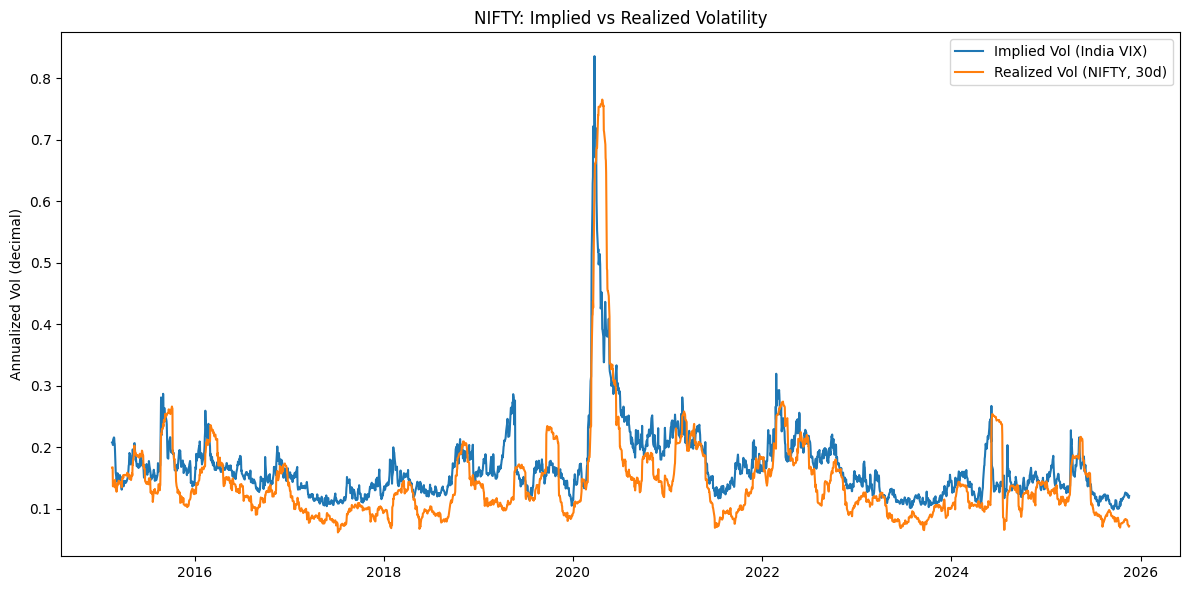

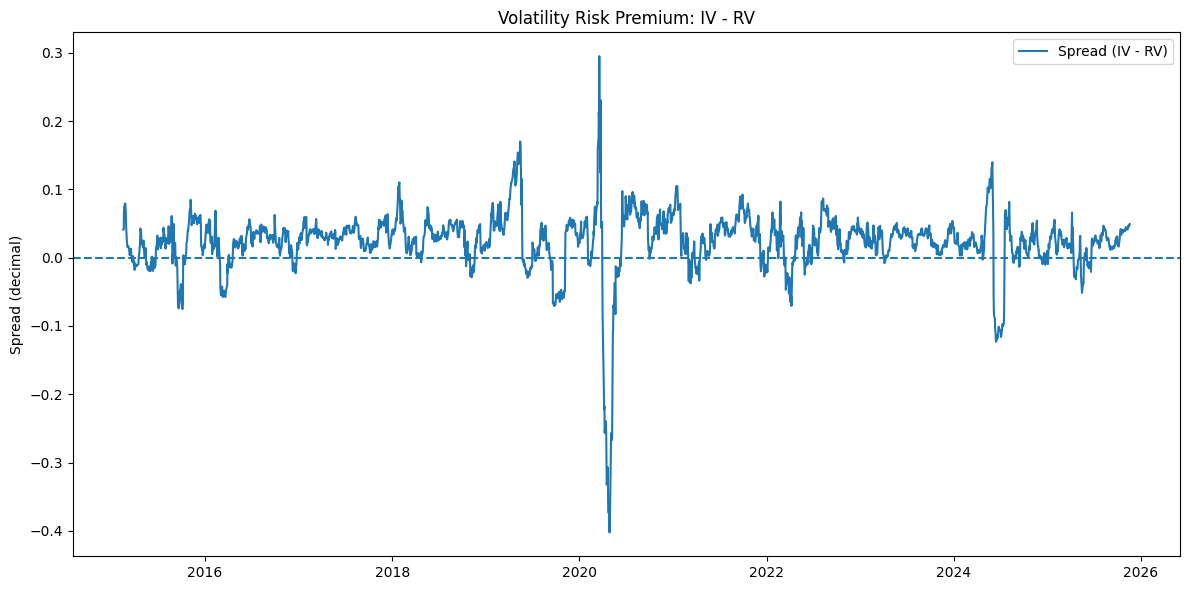

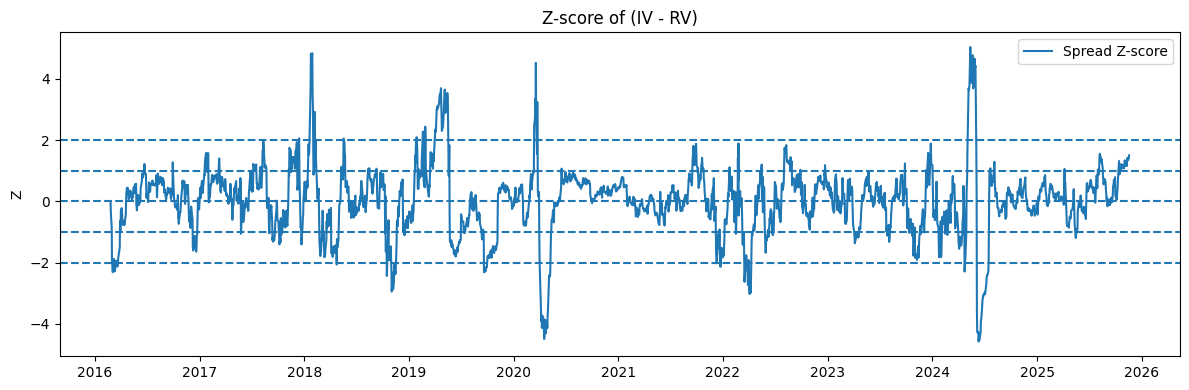

Regime frequency (long vol = 1, flat = 0, short vol = -1):
signal
-1    0.099924
 0    0.773556
 1    0.126520
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
START = "2015-01-01"
HORIZON = 30          # RV window to match VIX's ~30d horizon
TRADING_DAYS = 252
ZSCORE_LOOKBACK = 252 # 1Y rolling window for z-score baseline

# -----------------------------
# Download data
# -----------------------------
nifty = yf.download("^NSEI", start=START)
ivix  = yf.download("^INDIAVIX", start=START)

# Realized vol (annualized) from NIFTY returns
nifty["log_ret"] = np.log(nifty["Close"]).diff()
nifty["RV"] = nifty["log_ret"].rolling(HORIZON).std() * np.sqrt(TRADING_DAYS)

# Implied vol from India VIX (percent → decimal)
ivix["IV"] = ivix["Close"] / 100.0

# Merge & align
df = pd.concat([nifty["RV"], ivix["IV"]], axis=1).dropna()
df.columns = ["RV", "IV"]
df["Spread"] = df["IV"] - df["RV"]

# Z-score of the spread
roll_mean = df["Spread"].rolling(ZSCORE_LOOKBACK).mean()
roll_std  = df["Spread"].rolling(ZSCORE_LOOKBACK).std()
df["Spread_Z"] = (df["Spread"] - roll_mean) / roll_std

# -----------------------------
# Quick diagnostics
# -----------------------------
print("Correlation(IV, RV):", round(df["IV"].corr(df["RV"]), 3))
print("Avg IV:", round(df["IV"].mean(), 4),
      "Avg RV:", round(df["RV"].mean(), 4),
      "Avg (IV-RV):", round(df["Spread"].mean(), 4))

# Mean-reversion sanity checks
# 1) Lag-1 autocorrelation: closer to negative/low positive suggests faster reversion
lag1_autocorr = df["Spread"].pct_change().corr(df["Spread"].pct_change().shift(1))
print("Lag-1 autocorr of Spread changes:", round(lag1_autocorr, 3))

# 2) OU half-life estimate (Engle-Granger style)
#    Regress dS on S_{t-1}: dS = k*(mu - S_{t-1}) + noise => half-life = ln(2)/|k|
s = df["Spread"].dropna()
ds = s.diff().dropna()
s_lag = s.shift(1).dropna().loc[ds.index]
# OLS slope on s_{t-1}
k_hat = -np.polyfit(s_lag.values, ds.values, 1)[0]
half_life_days = np.log(2) / max(k_hat, 1e-8)
print("Approx OU half-life (trading days):", round(half_life_days, 1))

# -----------------------------
# Plots
# -----------------------------
# 1) IV vs RV
plt.figure(figsize=(12,6))
plt.plot(df.index, df["IV"], label="Implied Vol (India VIX)")
plt.plot(df.index, df["RV"], label=f"Realized Vol (NIFTY, {HORIZON}d)")
plt.title("NIFTY: Implied vs Realized Volatility")
plt.ylabel("Annualized Vol (decimal)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Spread and its z-score
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df.index, df["Spread"], label="Spread (IV - RV)")
ax.axhline(0, linestyle="--")
ax.set_title("Volatility Risk Premium: IV - RV")
ax.set_ylabel("Spread (decimal)")
ax.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df.index, df["Spread_Z"], label="Spread Z-score")
plt.axhline( 1.0, linestyle="--")
plt.axhline( 2.0, linestyle="--")
plt.axhline( 0.0, linestyle="--")
plt.axhline(-1.0, linestyle="--")
plt.axhline(-2.0, linestyle="--")
plt.title("Z-score of (IV - RV)")
plt.ylabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Simple signal idea (for research)
# -----------------------------
# When z > +1: IV >> RV → expect mean reversion down → short vol regime
# When z < -1: IV << RV → expect mean reversion up → long vol regime
df["signal"] = 0
df.loc[df["Spread_Z"] >  1.0, "signal"] = -1  # short vol
df.loc[df["Spread_Z"] < -1.0, "signal"] =  1  # long vol

# NOTE: This is just a *regime indicator*. To convert into PnL,
# you’d need an options replication (e.g., straddle returns) or
# a variance swap proxy. Here we just show how often each regime occurs:
regime_counts = df["signal"].value_counts(normalize=True).sort_index()
print("Regime frequency (long vol = 1, flat = 0, short vol = -1):")
print(regime_counts)


/tmp/ipython-input-121232569.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start=START)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-121232569.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ivix  = yf.download("^INDIAVIX", start=START)
[*********************100%***********************]  1 of 1 completed


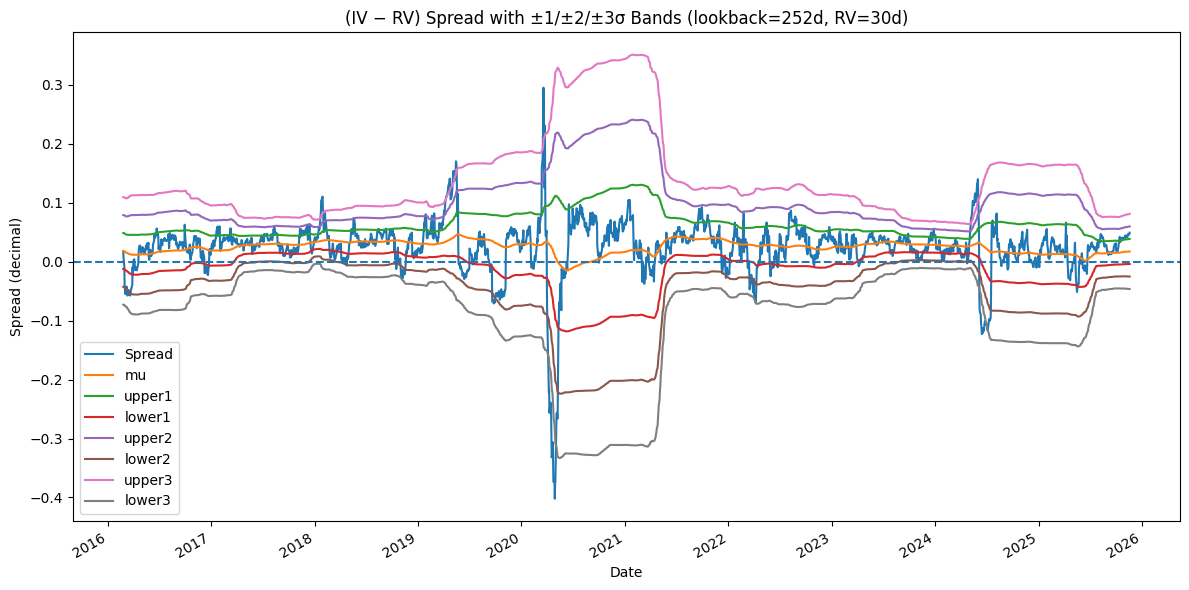

Breach frequencies (two-sided):
|Z| ≥ 1 : 25.03%
|Z| ≥ 2 : 7.22%
|Z| ≥ 3 : 3.61%
regime
neutral               0.749685
long vol (IV<<RV)     0.139857
short vol (IV>>RV)    0.110458
Name: Regime frequency, dtype: float64


/tmp/ipython-input-121232569.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["regime"] = "neutral"


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
START = "2015-01-01"
TRADING_DAYS = 252
RV_WINDOW = 30          # ~1 month to match VIX horizon
BOLL_LOOKBACK = 252     # 1Y rolling bands and z-score

# -----------------------------
# Download data
# -----------------------------
nifty = yf.download("^NSEI", start=START)
ivix  = yf.download("^INDIAVIX", start=START)

# -----------------------------
# Compute RV (annualized) and IV (decimal)
# -----------------------------
nifty["log_ret"] = np.log(nifty["Close"]).diff()
nifty["RV"] = nifty["log_ret"].rolling(RV_WINDOW).std() * np.sqrt(TRADING_DAYS)

ivix["IV"] = ivix["Close"] / 100.0

# Merge & align
df = pd.concat([nifty["RV"], ivix["IV"]], axis=1).dropna()
df.columns = ["RV", "IV"]

# Spread = IV - RV
df["Spread"] = df["IV"] - df["RV"]

# Rolling mean & std of spread (for bands)
df["mu"]  = df["Spread"].rolling(BOLL_LOOKBACK).mean()
df["sig"] = df["Spread"].rolling(BOLL_LOOKBACK).std()

# Bands
for k in (1, 2, 3):
    df[f"upper{k}"] = df["mu"] + k*df["sig"]
    df[f"lower{k}"] = df["mu"] - k*df["sig"]

# Z-score (optional)
df["Z"] = (df["Spread"] - df["mu"]) / df["sig"]

# -----------------------------
# Plot: Spread with ±1/±2/±3σ bands
# -----------------------------
ax = df[["Spread","mu","upper1","lower1","upper2","lower2","upper3","lower3"]].dropna().plot(figsize=(12,6))
ax.set_title(f"(IV − RV) Spread with ±1/±2/±3σ Bands (lookback={BOLL_LOOKBACK}d, RV={RV_WINDOW}d)")
ax.set_ylabel("Spread (decimal)")
ax.axhline(0.0, linestyle="--")
plt.tight_layout()
plt.show()

# -----------------------------
# Breach frequencies
# -----------------------------
valid = df.dropna(subset=["Z"])
p_ge_1 = (valid["Z"].abs() >= 1).mean()
p_ge_2 = (valid["Z"].abs() >= 2).mean()
p_ge_3 = (valid["Z"].abs() >= 3).mean()

print("Breach frequencies (two-sided):")
print(f"|Z| ≥ 1 : {p_ge_1:.2%}")
print(f"|Z| ≥ 2 : {p_ge_2:.2%}")
print(f"|Z| ≥ 3 : {p_ge_3:.2%}")

# -----------------------------
# Simple regime tags (optional)
# -----------------------------
valid["regime"] = "neutral"
valid.loc[ valid["Z"] >  1, "regime"] = "short vol (IV>>RV)"
valid.loc[ valid["Z"] < -1, "regime"] = "long vol (IV<<RV)"
print(valid["regime"].value_counts(normalize=True).rename("Regime frequency"))


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# CONFIG
START = "2015-01-01"
RV_HORIZON = 30         # forward realized window in days (t+1 .. t+30)
TRADING_DAYS = 252

# 1) Download data
vix_raw = yf.download("^INDIAVIX", start=START, progress=False)
nifty_raw = yf.download("^NSEI", start=START, progress=False)

# Quick availability check
print("VIX rows:", len(vix_raw), "NIFTY rows:", len(nifty_raw))
if vix_raw.empty:
    raise RuntimeError("India VIX (^INDIAVIX) returned no data from yfinance. Check ticker or internet.")
if nifty_raw.empty:
    raise RuntimeError("NIFTY (^NSEI) returned no data from yfinance. Check ticker or internet.")

# Use Close columns and align indices
vix = vix_raw['Close']
vix.name = 'VIX'

nifty = nifty_raw['Close']
nifty.name = 'NIFTY'


# 2) Compute log returns for NIFTY
nifty_ret = np.log(nifty / nifty.shift(1))

# 3) Compute forward realized volatility over next RV_HORIZON days
# We want RV_t = std( log_ret_{t+1..t+H} ) * sqrt(TRADING_DAYS)
# Implementation trick: compute rolling std on the *forward* window by reversing series or shifting after rolling.
rv_forward = nifty_ret.rolling(window=RV_HORIZON).std().shift(-RV_HORIZON+1) * sqrt(TRADING_DAYS)
rv_forward.name = f'FRV_{RV_HORIZON}d'

# 4) Prepare IV series (VIX is quoted in percent in Yahoo; convert to decimal to match RV)
# Note: if you prefer both in percent, keep both in percent — just be consistent.
# I'll convert VIX percent -> decimal (e.g., 15 -> 0.15) to match rv_forward (decimal).
vix_decimal = vix / 100.0
vix_decimal.name = 'IV'

# 5) Merge and inspect
df = pd.concat([vix_decimal, rv_forward], axis=1)
print("\nMerged head:")
print(df.head(10))
print("\nMerged tail:")
print(df.tail(10))

print("\nCount non-NaN values:")
# Access columns using multi-level indexing: (Ticker, original column name)
print(df[[('^INDIAVIX', 'Close'), ('^NSEI', 'Close')]].notna().sum())

# 6) Drop rows where either is NaN (these cause empty plots)
# Access columns using multi-level indexing: (Ticker, original column name)
df_plot = df.dropna(subset=[('^INDIAVIX', 'Close'), ('^NSEI', 'Close')]).copy()

# Rename columns for easier access
df_plot = df_plot.rename(columns={('^INDIAVIX', 'Close'): 'IV', ('^NSEI', 'Close'): f'FRV_{RV_HORIZON}d'})

print(f"\nRows available for plotting after dropna: {len(df_plot)}")

if df_plot.empty:
    # Helpful diagnostics when empty
    print("\n--- Diagnostic hints ---")
    print("1) FRV will be NaN for the last RV_HORIZON-1 rows (not enough forward data).")
    print("2) If VIX data frequency/timestamps differ from NIFTY, index alignment may yield no overlap.")
    print("3) If you fetched VIX from a different source, make sure the dates match trading days.")
    raise RuntimeError("No overlapping non-NaN data to plot. See diagnostics above.")

# 7) Compute spread and plot
df_plot['Spread'] = df_plot['IV'] - df_plot[f'FRV_{RV_HORIZON}d']

plt.figure(figsize=(12,5))
plt.plot(df_plot.index, df_plot['IV'], label='IV (decimal)')
plt.plot(df_plot.index, df_plot[f'FRV_{RV_HORIZON}d'], label=f'Forward Realized Vol {RV_HORIZON}d (decimal)')
plt.title('IV vs Forward Realized Vol (aligned)')
plt.ylabel('Annualized vol (decimal)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df_plot.index, df_plot['Spread'])
plt.axhline(0, linestyle='--', color='k')
plt.title('IV - FRV Spread')
plt.ylabel('IV - FRV (decimal)')
plt.grid(True)
plt.show()

# 8) Quick stats
print("\nSummary stats (first/last available):")
print("Date range:", df_plot.index.min().date(), "to", df_plot.index.max().date())
print("Mean spread:", df_plot['Spread'].mean())
print("Std spread:", df_plot['Spread'].std())
print("Correlation IV vs FRV:", df_plot['IV'].corr(df_plot[f'FRV_{RV_HORIZON}d']))

/tmp/ipython-input-2086117251.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download("^INDIAVIX", start=START, progress=False)
/tmp/ipython-input-2086117251.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_raw = yf.download("^NSEI", start=START, progress=False)


VIX rows: 2668 NIFTY rows: 2678

Merged head:
Ticker      ^INDIAVIX     ^NSEI
Date                           
2015-01-01     0.1503       NaN
2015-01-02     0.1380       NaN
2015-01-05     0.1415  0.167361
2015-01-06     0.1742  0.167641
2015-01-07     0.1814  0.136798
2015-01-08     0.1647  0.138736
2015-01-09     0.1596  0.136868
2015-01-12     0.1611  0.136378
2015-01-13     0.1648  0.136169
2015-01-14     0.1725  0.139482

Merged tail:
Ticker      ^INDIAVIX  ^NSEI
Date                        
2025-11-04   0.126500    NaN
2025-11-06   0.124100    NaN
2025-11-07   0.125600    NaN
2025-11-10   0.123000    NaN
2025-11-11   0.124900    NaN
2025-11-12   0.121100    NaN
2025-11-13   0.121600    NaN
2025-11-14   0.119400    NaN
2025-11-17   0.117900    NaN
2025-11-18   0.121075    NaN

Count non-NaN values:


KeyError: "None of [Index([('^INDIAVIX', 'Close'), ('^NSEI', 'Close')], dtype='object', name='Ticker')] are in the [columns]"

Overlap rows: 2,628
India VIX vs YZ 30D Forward RV correlation: 0.528


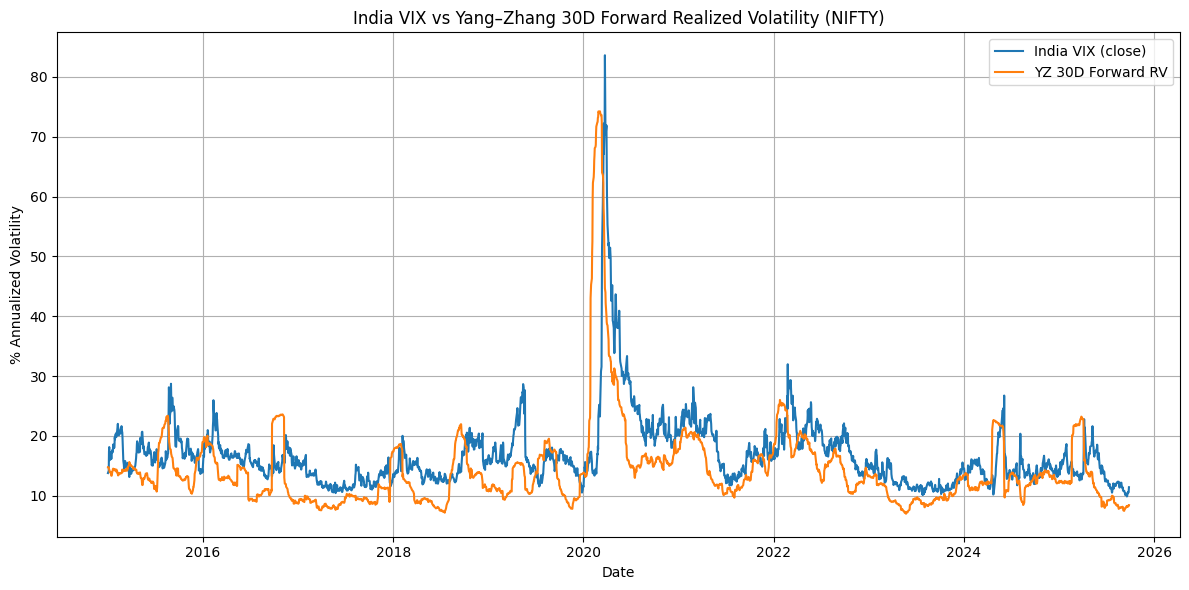

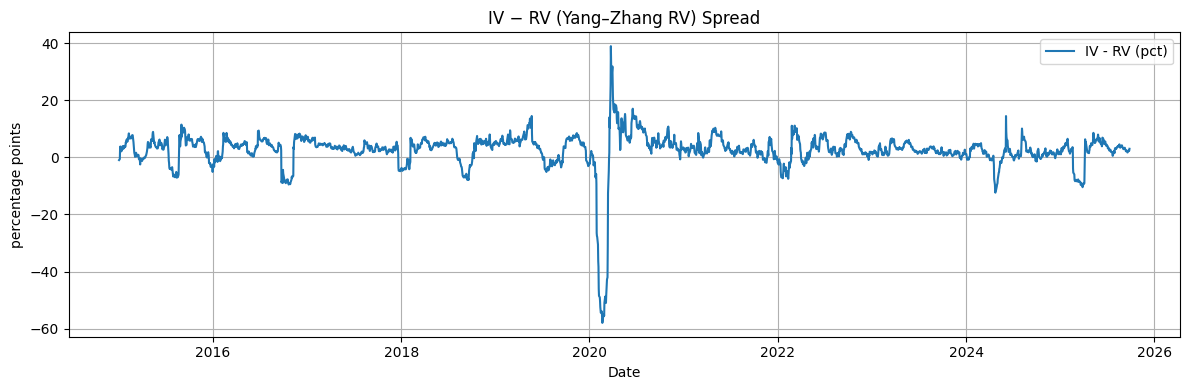

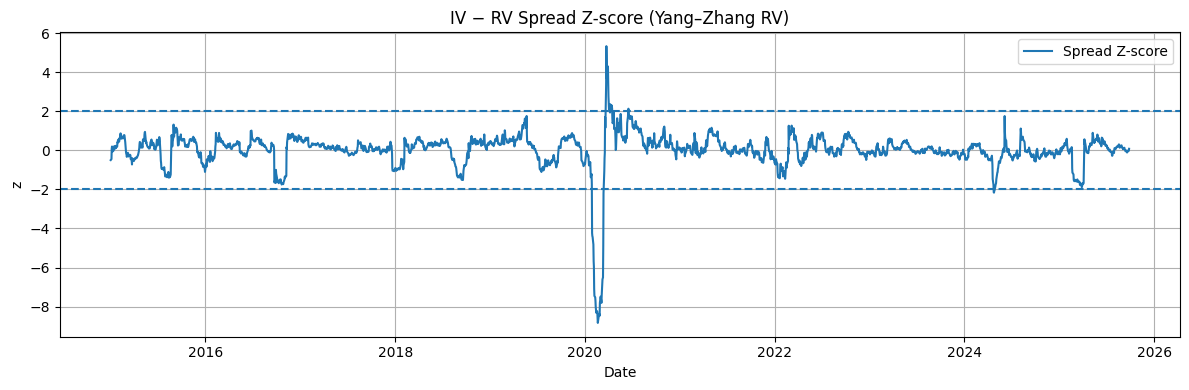

In [ ]:
"""
Compute Yang–Zhang realized volatility for NIFTY and compare it to India VIX.

Notes
-----
- India VIX (IV) is forward-looking (next 30 calendar days). We compare it to a
  *forward* 30-trading-day realized volatility using the Yang–Zhang (YZ) estimator.
- YZ combines overnight (close→open), open→close, and Rogers–Satchell terms to reduce
  bias from microstructure noise and jumps.
- This script aligns dates as follows: the value on date t for RV_YZ_30F uses
  the window [t+1 .. t+30], i.e., what actually realized after the close on t.

How to use
----------
1) Ensure `pip install yfinance pandas numpy matplotlib`.
2) Run the script. Internet is required to download ^NSEI and ^INDIAVIX from Yahoo.
3) The plot will show: India VIX (close) vs 30D forward Yang–Zhang RV.
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

try:
    import yfinance as yf
except ImportError:
    yf = None

TRADING_DAYS = 252  # used for annualization


def _safe_log(x: pd.Series, eps: float = 1e-12) -> pd.Series:
    """Numerical guard for log; also handles non-positive inputs by clipping."""
    x = x.astype(float)
    return np.log(x.clip(lower=eps))


def yang_zhang_window(
    ohlc: pd.DataFrame,
    window: int,
    *,
    annualize: bool = True,
) -> pd.Series:
    """Rolling Yang–Zhang volatility (per-day estimator over each rolling window).

    Parameters
    ----------
    ohlc : DataFrame with columns ['Open','High','Low','Close'] indexed by date.
    window : int, rolling window length in trading days.
    annualize : bool, if True multiply daily sigma by sqrt(252).

    Returns
    -------
    pd.Series of annualized volatility (in decimal, e.g., 0.18 = 18%).

    References
    ----------
    Yang, D. and Zhang, Q. (2000). "Drift-independent volatility estimation
    based on high, low, open and close prices". Journal of Business.

    Formula (window n):
      u_t = ln(O_t / C_{t-1})      # overnight (close→open)
      r_t = ln(C_t / O_t)          # open→close
      RS_t = ln(H_t/O_t)*ln(H_t/C_t) + ln(L_t/O_t)*ln(L_t/C_t)  # Rogers–Satchell

      sigma_o^2 = Var(u_t)
      sigma_c^2 = Var(r_t)
      sigma_rs  = mean(RS_t)
      k = 0.34 / (1.34 + (n + 1)/(n - 1))

      sigma_yz^2 = sigma_o^2 + k*sigma_c^2 + (1 - k)*sigma_rs
    """
    required = {"Open", "High", "Low", "Close"}
    if not required.issubset(set(ohlc.columns)):
        raise ValueError(f"ohlc must contain {required}")

    df = ohlc.copy().astype(float)
    df = df.dropna(subset=["Open", "High", "Low", "Close"]).copy()

    # Logs
    log_o = _safe_log(df["Open"])
    log_h = _safe_log(df["High"])
    log_l = _safe_log(df["Low"])
    log_c = _safe_log(df["Close"])

    # Overnight u_t uses previous close
    log_c_prev = log_c.shift(1)
    u = log_o - log_c_prev            # close→open
    r = log_c - log_o                 # open→close

    # Rogers–Satchell term for each day (uses same-day O, H, L, C)
    rs = (log_h - log_o) * (log_h - log_c) + (log_l - log_o) * (log_l - log_c)

    n = window
    if n < 2:
        raise ValueError("window must be >= 2")

    # Yang–Zhang weight k
    k = 0.34 / (1.34 + (n + 1) / (n - 1))

    # Rolling components
    sigma_o2 = u.rolling(n).var(ddof=1)
    sigma_c2 = r.rolling(n).var(ddof=1)
    sigma_rs = rs.rolling(n).mean()

    yz_var = sigma_o2 + k * sigma_c2 + (1 - k) * sigma_rs
    yz_var = yz_var.clip(lower=0)  # guard
    yz_sigma_daily = np.sqrt(yz_var)

    if annualize:
        yz_sigma = yz_sigma_daily * sqrt(TRADING_DAYS)
    else:
        yz_sigma = yz_sigma_daily

    yz_sigma.name = f"YZ_vol_{window}d"
    return yz_sigma


def forward_window_yz(
    ohlc: pd.DataFrame,
    window: int,
    *,
    annualize: bool = True,
) -> pd.Series:
    """Forward 30D (or N) realized vol aligned at date t, using YZ estimator.

    The value at index t uses the period [t+1 .. t+window].
    """
    yz = yang_zhang_window(ohlc, window=window, annualize=annualize)
    # Shift backward so that the window that *follows* t is aligned on t
    out = yz.shift(-window).copy()
    out.name = f"YZ_vol_{window}d_forward"
    return out


def load_data(start: str = "2015-01-01") -> tuple[pd.DataFrame, pd.Series]:
    if yf is None:
        raise RuntimeError("yfinance is not installed. `pip install yfinance`.")
    nifty = yf.download("^NSEI", start=start, auto_adjust=False, progress=False)
    vix = yf.download("^INDIAVIX", start=start, auto_adjust=False, progress=False)
    if nifty.empty or vix.empty:
        raise RuntimeError("Failed to download ^NSEI or ^INDIAVIX from Yahoo.")

    # Flatten any potential MultiIndex columns (yfinance can sometimes return them)
    if isinstance(nifty.columns, pd.MultiIndex):
        nifty.columns = nifty.columns.get_level_values(0)
    if isinstance(vix.columns, pd.MultiIndex):
        vix.columns = vix.columns.get_level_values(0)

    ohlc = nifty[["Open", "High", "Low", "Close"]].copy()
    vix_close = vix["Close"].copy(); vix_close.name = "IndiaVIX"

    # Use concat on index to avoid merge-level mismatches
    joined = pd.concat([ohlc, vix_close], axis=1, join="inner")
    joined = joined.dropna(subset=["Open", "High", "Low", "Close", "IndiaVIX"])

    return joined[["Open","High","Low","Close"]], joined["IndiaVIX"]


def main():
    START = "2015-01-01"
    WINDOW = 30  # trading days; ~1.5 months

    ohlc, vix = load_data(start=START)

    # Forward 30D YZ realized vol, annualized, in decimal
    yz_fwd = forward_window_yz(ohlc, window=WINDOW, annualize=True)

    # Scale to percent for plotting to match VIX scale
    yz_pct = (yz_fwd * 100).copy(); yz_pct.name = "YZ 30D Forward RV (%)"
    vix_pct = vix.copy(); vix_pct.name = "India VIX (%)"

    df = pd.concat([vix_pct, yz_pct], axis=1).dropna()

    # Quick correlation on overlapping dates
    corr = df.corr().iloc[0, 1]
    print(f"Overlap rows: {len(df):,}")
    print(f"India VIX vs YZ 30D Forward RV correlation: {corr:.3f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["India VIX (%)"], label="India VIX (close)")
    plt.plot(df.index, df["YZ 30D Forward RV (%)"], label="YZ 30D Forward RV")
    plt.title("India VIX vs Yang–Zhang 30D Forward Realized Volatility (NIFTY)")
    plt.xlabel("Date")
    plt.ylabel("% Annualized Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Also provide the IV–RV spread and a simple z-score band for mean-reversion studies
    spread = (df["India VIX (%)"] - df["YZ 30D Forward RV (%)"]).rename("IV_minus_RV (pct)")
    z = ((spread - spread.mean()) / spread.std()).rename("Spread Z-score")

    # Optional: plot spread
    plt.figure(figsize=(12, 4))
    plt.plot(spread.index, spread.values, label="IV - RV (pct)")
    plt.title("IV − RV (Yang–Zhang RV) Spread")
    plt.xlabel("Date")
    plt.ylabel("percentage points")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: plot z-score
    plt.figure(figsize=(12, 4))
    plt.plot(z.index, z.values, label="Spread Z-score")
    plt.axhline(2.0, linestyle="--")
    plt.axhline(-2.0, linestyle="--")
    plt.title("IV − RV Spread Z-score (Yang–Zhang RV)")
    plt.xlabel("Date")
    plt.ylabel("z")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
